In [102]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from wordcloud import WordCloud
import warnings

# Set display options
pd.set_option('display.max_columns', None)
warnings.filterwarnings('ignore')

# Set basic style for visualizations
plt.style.use('default')
sns.set_theme(style="whitegrid")

# Read the dataset
df = pd.read_csv('netflix_titles.csv')

# Display basic information about the dataset
print("Dataset Info:")
print("-" * 50)
print(df.info())
print("\nFirst few rows:")
print("-" * 50)
display(df.head())


Dataset Info:
--------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8807 entries, 0 to 8806
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8807 non-null   object
 1   type          8807 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7982 non-null   object
 5   country       7976 non-null   object
 6   date_added    8797 non-null   object
 7   release_year  8807 non-null   int64 
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8807 non-null   object
 11  description   8807 non-null   object
dtypes: int64(1), object(11)
memory usage: 825.8+ KB
None

First few rows:
--------------------------------------------------


,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,NaN,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,NaN,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",NaN,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,NaN,NaN,NaN,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,NaN,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...


In [103]:
# Data Preprocessing
def preprocess_data(df):
    """Preprocess the Netflix dataset"""
    # Create a copy of the dataframe
    df = df.copy()
    
    # Clean and convert date_added to datetime
    df['date_added'] = df['date_added'].str.strip()
    df['date_added'] = pd.to_datetime(df['date_added'], format='mixed')
    
    # Extract year and month from date_added
    df['year_added'] = df['date_added'].dt.year
    df['month_added'] = df['date_added'].dt.month
    
    # Convert release_year to numeric
    df['release_year'] = pd.to_numeric(df['release_year'])
    
    # Split duration into numeric value and unit
    df[['duration_value', 'duration_unit']] = df['duration'].str.extract('(\d+)\s+(\w+)')
    df['duration_value'] = pd.to_numeric(df['duration_value'])
    
    # Process list-like columns
    for col in ['cast', 'director', 'listed_in', 'country']:
        df[col] = df[col].fillna('')
        df[col] = df[col].str.split(',')
        df[col] = df[col].apply(lambda x: [item.strip() for item in x] if isinstance(x, list) else [])
    
    return df

# Apply preprocessing
df_clean = preprocess_data(df)

# Display basic statistics after preprocessing
print("Dataset shape:", df_clean.shape)
print("\nMissing values:")
print(df_clean.isnull().sum())
print("\nBasic statistics for numeric columns:")
display(df_clean.describe())


Dataset shape: (8807, 16)

Missing values:
show_id            0
type               0
title              0
director           0
cast               0
country            0
date_added        10
release_year       0
rating             4
duration           3
listed_in          0
description        0
year_added        10
month_added       10
duration_value     3
duration_unit      3
dtype: int64

Basic statistics for numeric columns:


,date_added,release_year,year_added,month_added,duration_value
count,8797,8807.000000,8797.000000,8797.000000,8804.000000
mean,2019-05-17 05:59:08.436967168,2014.180198,2018.871888,6.654996,69.846888
min,2008-01-01 00:00:00,1925.000000,2008.000000,1.000000,1.000000
25%,2018-04-06 00:00:00,2013.000000,2018.000000,4.000000,2.000000
50%,2019-07-02 00:00:00,2017.000000,2019.000000,7.000000,88.000000
75%,2020-08-19 00:00:00,2019.000000,2020.000000,10.000000,106.000000
max,2021-09-25 00:00:00,2021.000000,2021.000000,12.000000,312.000000
std,NaN,8.819312,1.574243,3.436554,50.814828


<Figure size 1200x600 with 0 Axes>

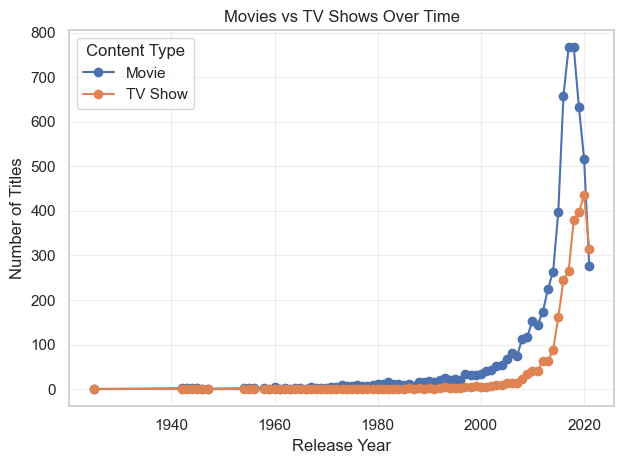


Content Production During COVID-19 Period (2018-2022):


type,Movie,TV Show
release_year,,
2018,767,380
2019,633,397
2020,517,436
2021,277,315



Year-over-Year Growth Rates (%):


type,Movie,TV Show
release_year,,
2018,NaN,NaN
2019,-17.47,4.47
2020,-18.33,9.82
2021,-46.42,-27.75


In [105]:
# Content Growth Analysis

# Plot: Movies vs TV Shows Over Time
type_by_year = df_clean.groupby(['release_year', 'type']).size().unstack().fillna(0)

plt.figure(figsize=(12, 6))
type_by_year.plot(kind='line', marker='o')
plt.title('Movies vs TV Shows Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.legend(title='Content Type')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# COVID-19 Impact Analysis (2018-2022)
covid_period = df_clean[df_clean['release_year'].between(2018, 2022)]
covid_analysis = covid_period.groupby(['release_year', 'type']).size().unstack().fillna(0)
print("\nContent Production During COVID-19 Period (2018-2022):")
display(covid_analysis)

# Calculate year-over-year growth rates
yoy_growth = covid_analysis.pct_change() * 100
print("\nYear-over-Year Growth Rates (%):")
display(yoy_growth.round(2))


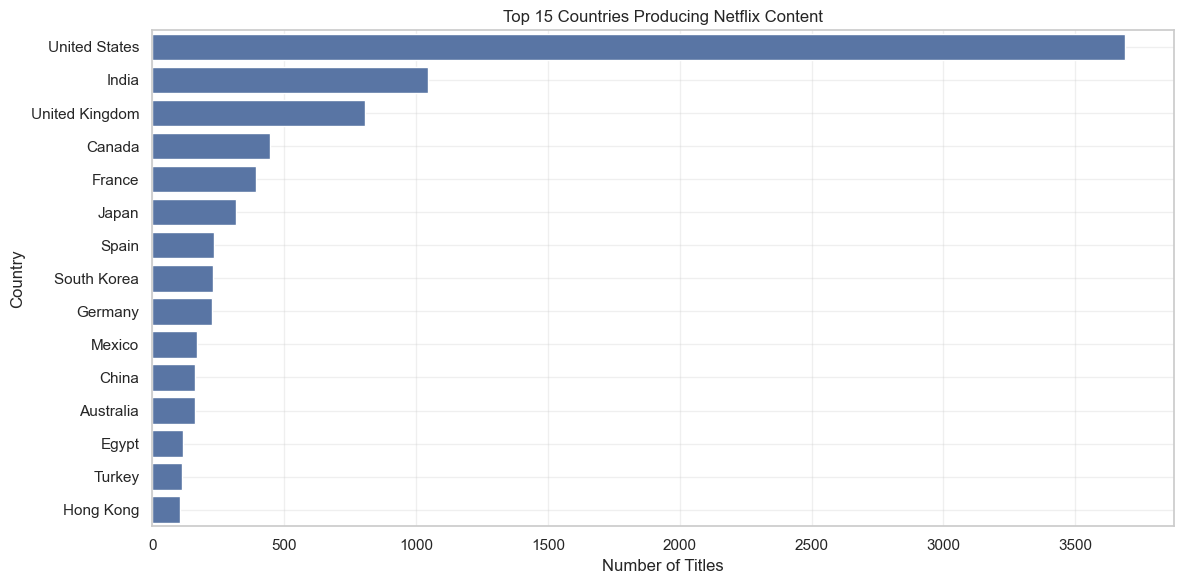


Content Diversity Statistics:
Total number of content pieces with country information: 8807
Number of unique countries producing content: 122


In [107]:
# Geographic Analysis

def count_content_by_country(country_lists):
    """Count content per country from list of countries"""
    country_counts = {}
    for countries in country_lists:
        if isinstance(countries, list):
            for country in countries:
                if country:
                    country_counts[country] = country_counts.get(country, 0) + 1
    return pd.Series(country_counts).sort_values(ascending=False)

# Get top 15 content-producing countries
top_countries = count_content_by_country(df_clean['country'])[:15]

# Create bar plot for top countries
plt.figure(figsize=(12, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 15 Countries Producing Netflix Content')
plt.xlabel('Number of Titles')
plt.ylabel('Country')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Content diversity statistics
total_countries = sum(1 for countries in df_clean['country'] if isinstance(countries, list) and countries)
unique_countries = len(set([country for countries in df_clean['country'] 
                          if isinstance(countries, list) 
                          for country in countries if country]))

print(f"\nContent Diversity Statistics:")
print(f"Total number of content pieces with country information: {total_countries}")
print(f"Number of unique countries producing content: {unique_countries}")


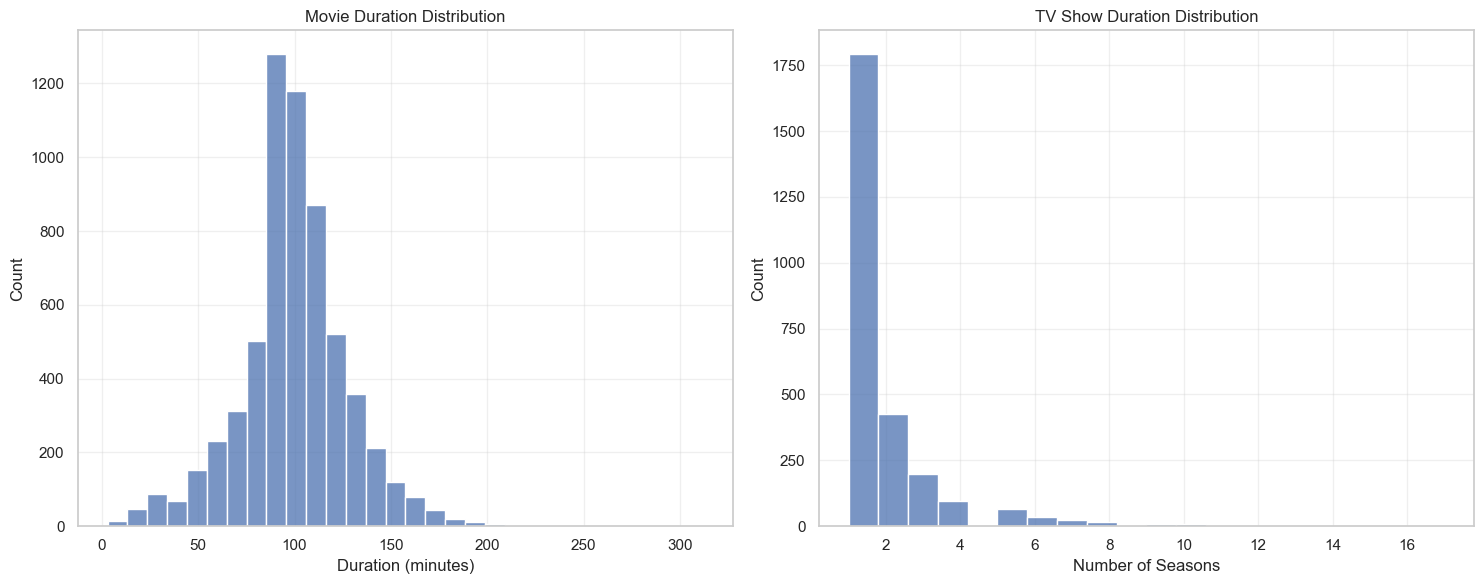


Duration Statistics:

Movies:
Average duration: 99.6 minutes
Median duration: 98.0 minutes
Most common duration: 90.0 minutes

TV Shows:
Average seasons: 1.8
Median seasons: 1.0
Most common number of seasons: 1.0


In [109]:
# Duration Analysis

# Separate movies and TV shows
movies = df_clean[df_clean['type'] == 'Movie']
tv_shows = df_clean[df_clean['type'] == 'TV Show']

# Create duration distribution plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Movie duration distribution
sns.histplot(data=movies, x='duration_value', bins=30, ax=ax1)
ax1.set_title('Movie Duration Distribution')
ax1.set_xlabel('Duration (minutes)')
ax1.grid(True, alpha=0.3)

# TV Show duration distribution
sns.histplot(data=tv_shows, x='duration_value', bins=20, ax=ax2)
ax2.set_title('TV Show Duration Distribution')
ax2.set_xlabel('Number of Seasons')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nDuration Statistics:")
print("\nMovies:")
print(f"Average duration: {movies['duration_value'].mean():.1f} minutes")
print(f"Median duration: {movies['duration_value'].median():.1f} minutes")
print(f"Most common duration: {movies['duration_value'].mode().iloc[0]:.1f} minutes")

print("\nTV Shows:")
print(f"Average seasons: {tv_shows['duration_value'].mean():.1f}")
print(f"Median seasons: {tv_shows['duration_value'].median():.1f}")
print(f"Most common number of seasons: {tv_shows['duration_value'].mode().iloc[0]:.1f}")


<Figure size 1500x600 with 0 Axes>

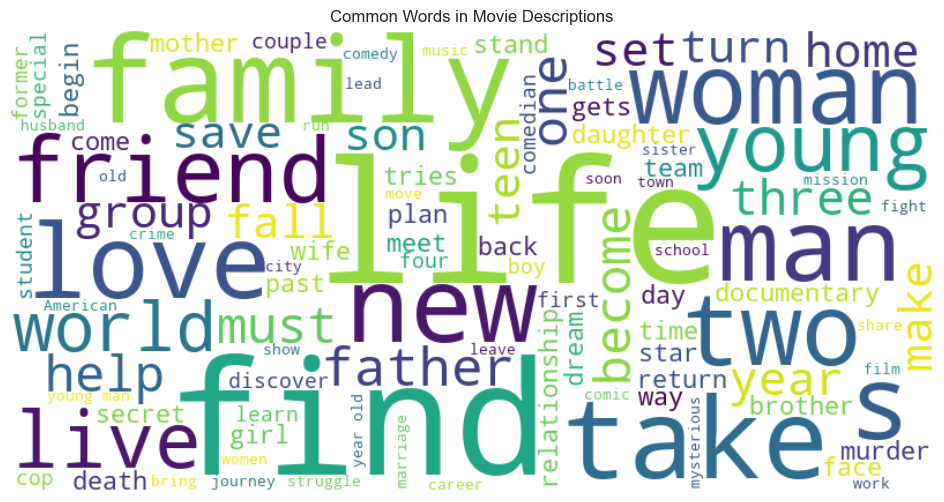

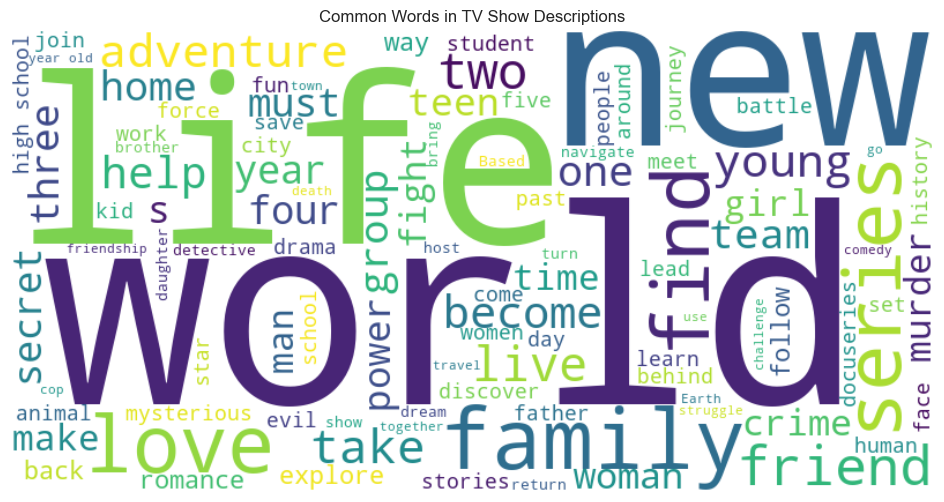


Description Statistics:
Average movie description length: 143.6 characters
Average TV show description length: 142.6 characters


In [111]:
# Content Description Analysis

def generate_wordcloud(text_data, title):
    """Generate and display a WordCloud"""
    wordcloud = WordCloud(width=800, height=400,
                         background_color='white',
                         max_words=100).generate(' '.join(text_data))
    
    plt.figure(figsize=(12, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Generate WordClouds for Movies and TV Shows
plt.figure(figsize=(15, 6))

# Movies WordCloud
movie_descriptions = movies['description'].dropna()
generate_wordcloud(movie_descriptions, 'Common Words in Movie Descriptions')

# TV Shows WordCloud
tvshow_descriptions = tv_shows['description'].dropna()
generate_wordcloud(tvshow_descriptions, 'Common Words in TV Show Descriptions')

# Print some statistics
print("\nDescription Statistics:")
print(f"Average movie description length: {movie_descriptions.str.len().mean():.1f} characters")
print(f"Average TV show description length: {tvshow_descriptions.str.len().mean():.1f} characters")


In [126]:
# Content Recommendation System

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

def get_recommendations(title, df, n_recommendations=5):
    """Get content recommendations based on title"""
    # Find the title in the dataset
    title_info = df[df['title'].str.lower() == title.lower()]
    
    if len(title_info) == 0:
        return "Title not found in the dataset."
    
    # Get the index of the title
    idx = title_info.index[0]
    
    # Create a string representation of genres
    df['genre_string'] = df['listed_in'].apply(lambda x: ' '.join(x) if isinstance(x, list) else '')
    
    # Combine description and genres for content similarity
    df['content'] = df['description'].fillna('') + ' ' + df['genre_string']
    
    # Create TF-IDF matrix
    tfidf = TfidfVectorizer(stop_words='english')
    tfidf_matrix = tfidf.fit_transform(df['content'])
    
    # Calculate similarity scores
    cosine_sim = cosine_similarity(tfidf_matrix[idx:idx+1], tfidf_matrix)
    
    # Get similarity scores for the title
    sim_scores = list(enumerate(cosine_sim[0]))
    
    # Sort based on similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Get top N most similar items (excluding the input title)
    sim_scores = sim_scores[1:n_recommendations+1]
    
    # Get the indices and scores
    indices = [i[0] for i in sim_scores]
    
    # Return recommended titles with similarity scores
    recommendations = pd.DataFrame({
        'Title': df['title'].iloc[indices],
        'Type': df['type'].iloc[indices],
        'Similarity Score': [i[1] for i in sim_scores],
        'Release Year': df['release_year'].iloc[indices]
    })
    
    return recommendations

# Example usage
example_title = df_clean['title'].iloc[0]  # Using first title as example
print(f"Getting recommendations for: {example_title}\n")
recommendations = get_recommendations(example_title, df_clean)
display(recommendations)


Getting recommendations for: Dick Johnson Is Dead



,Title,Type,Similarity Score,Release Year
4877,End Game,Movie,0.173581,2018
1066,The Soul,Movie,0.139453,2021
5233,The Death and Life of Marsha P. Johnson,Movie,0.133475,2017
7506,Moon,Movie,0.129728,2009
5047,The Cloverfield Paradox,Movie,0.121701,2018


Recommendation System Performance Metrics:
----------------------------------------
Average Similarity Score: 0.187
Average Genre Match Rate: 0.539
Average Year Difference: 7.876


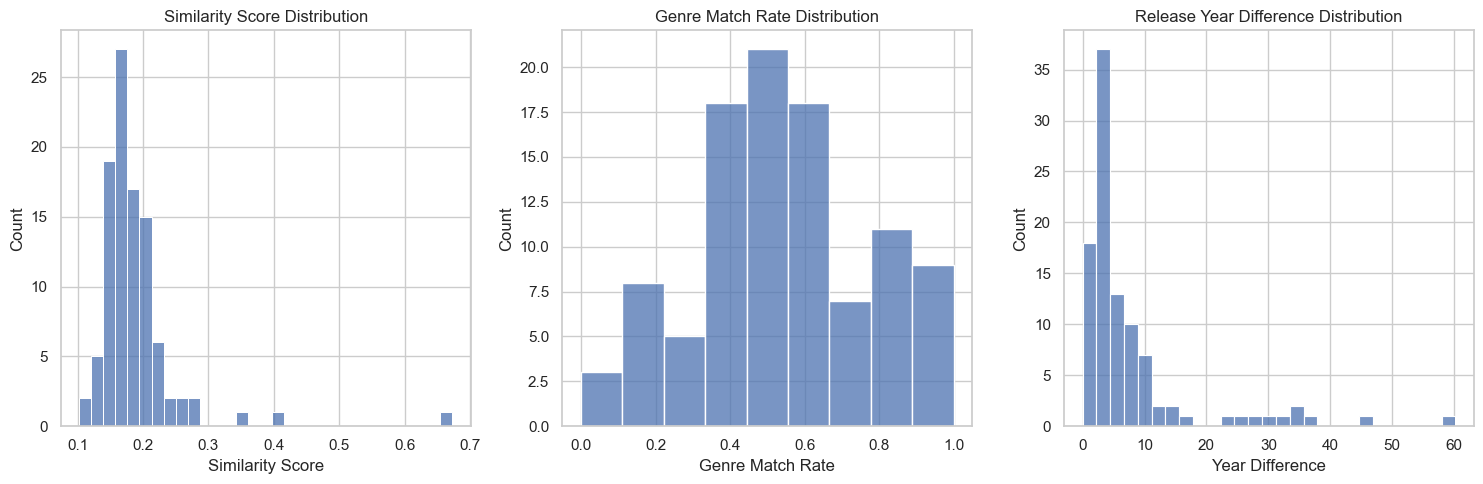


Detailed Statistics:
----------------------------------------
Similarity Scores:
- 25th percentile: 0.158
- Median: 0.174
- 75th percentile: 0.201

Genre Match Rates:
- 25th percentile: 0.400
- Median: 0.517
- 75th percentile: 0.675

Year Differences:
- 25th percentile: 2.8 years
- Median: 4.1 years
- 75th percentile: 8.1 years


In [135]:
# System Evaluation

def evaluate_recommendations(df, n_samples=100, n_recommendations=5):
    """Evaluate recommendation system performance"""
    # Sample random titles
    sample_titles = df['title'].sample(n=n_samples, random_state=42)
    
    # Metrics storage
    similarity_scores = []
    genre_match_rates = []
    year_differences = []
    
    for title in sample_titles:
        # Get recommendations
        recs = get_recommendations(title, df, n_recommendations)
        if isinstance(recs, str):  # Skip if title not found
            continue
            
        # 1. Average similarity score
        similarity_scores.append(recs['Similarity Score'].mean())
        
        # 2. Genre matching rate
        title_genres = set(df[df['title'] == title]['listed_in'].iloc[0])
        genre_matches = []
        
        for _, rec in recs.iterrows():
            rec_genres = set(df[df['title'] == rec['Title']]['listed_in'].iloc[0])
            if title_genres and rec_genres:  # Skip if either has no genres
                match_rate = len(title_genres.intersection(rec_genres)) / len(title_genres)
                genre_matches.append(match_rate)
        
        if genre_matches:
            genre_match_rates.append(np.mean(genre_matches))
            
        # 3. Release year proximity
        title_year = df[df['title'] == title]['release_year'].iloc[0]
        year_diff = abs(recs['Release Year'] - title_year).mean()
        year_differences.append(year_diff)
    
    # Calculate overall metrics
    results = {
        'Average Similarity Score': np.mean(similarity_scores),
        'Average Genre Match Rate': np.mean(genre_match_rates),
        'Average Year Difference': np.mean(year_differences)
    }
    
    return results, similarity_scores, genre_match_rates, year_differences

# Run evaluation
results, sim_scores, genre_rates, year_diffs = evaluate_recommendations(df_clean)

# Print results
print("Recommendation System Performance Metrics:")
print("-" * 40)
for metric, value in results.items():
    print(f"{metric}: {value:.3f}")

# Visualize distributions
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Similarity Scores
sns.histplot(sim_scores, ax=ax1)
ax1.set_title('Similarity Score Distribution')
ax1.set_xlabel('Similarity Score')

# Genre Match Rates
sns.histplot(genre_rates, ax=ax2)
ax2.set_title('Genre Match Rate Distribution')
ax2.set_xlabel('Genre Match Rate')

# Year Differences
sns.histplot(year_diffs, ax=ax3)
ax3.set_title('Release Year Difference Distribution')
ax3.set_xlabel('Year Difference')

plt.tight_layout()
plt.show()

# Additional insights
print("\nDetailed Statistics:")
print("-" * 40)
print("Similarity Scores:")
print(f"- 25th percentile: {np.percentile(sim_scores, 25):.3f}")
print(f"- Median: {np.median(sim_scores):.3f}")
print(f"- 75th percentile: {np.percentile(sim_scores, 75):.3f}")

print("\nGenre Match Rates:")
print(f"- 25th percentile: {np.percentile(genre_rates, 25):.3f}")
print(f"- Median: {np.median(genre_rates):.3f}")
print(f"- 75th percentile: {np.percentile(genre_rates, 75):.3f}")

print("\nYear Differences:")
print(f"- 25th percentile: {np.percentile(year_diffs, 25):.1f} years")
print(f"- Median: {np.median(year_diffs):.1f} years")
print(f"- 75th percentile: {np.percentile(year_diffs, 75):.1f} years")


In [113]:
# Content-based Recommendation System

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Create content strings for recommendations
def create_content_string(row):
    content = []
    if not pd.isna(row['description']):
        content.append(str(row['description']).lower())
    if isinstance(row['listed_in'], list):
        content.extend([genre.lower() for genre in row['listed_in']])
    if isinstance(row['cast'], list):
        content.extend([actor.lower() for actor in row['cast']])
    return ' '.join(content)

# Prepare data for recommendations
df_clean['content_string'] = df_clean.apply(create_content_string, axis=1)
tfidf = TfidfVectorizer(stop_words='english')
content_vectors = tfidf.fit_transform(df_clean['content_string'])

def get_recommendations(title, n=5):
    """Get n recommendations for a given title based on content similarity"""
    idx = df_clean[df_clean['title'] == title].index
    if len(idx) == 0:
        return "Title not found"
    
    title_vector = content_vectors[idx[0]]
    similarities = cosine_similarity(title_vector, content_vectors).flatten()
    similar_indices = similarities.argsort()[::-1][1:n+1]
    
    recommendations = df_clean.iloc[similar_indices][['title', 'type', 'listed_in']]
    recommendations['similarity_score'] = similarities[similar_indices]
    return recommendations

# Example recommendations
print("Example Recommendations:")
example_title = df_clean['title'].iloc[0]
print(f"\nRecommendations for '{example_title}':")
display(get_recommendations(example_title))


Example Recommendations:

Recommendations for 'Dick Johnson Is Dead':


,title,type,listed_in,similarity_score
4877,End Game,Movie,[Documentaries],0.183419
5797,Extremis,Movie,[Documentaries],0.121276
6038,A Gray State,Movie,[Documentaries],0.118804
8700,Wartime Portraits,TV Show,"[Docuseries, International TV Shows]",0.103773
5426,Counterpunch,Movie,"[Documentaries, Sports Movies]",0.103331


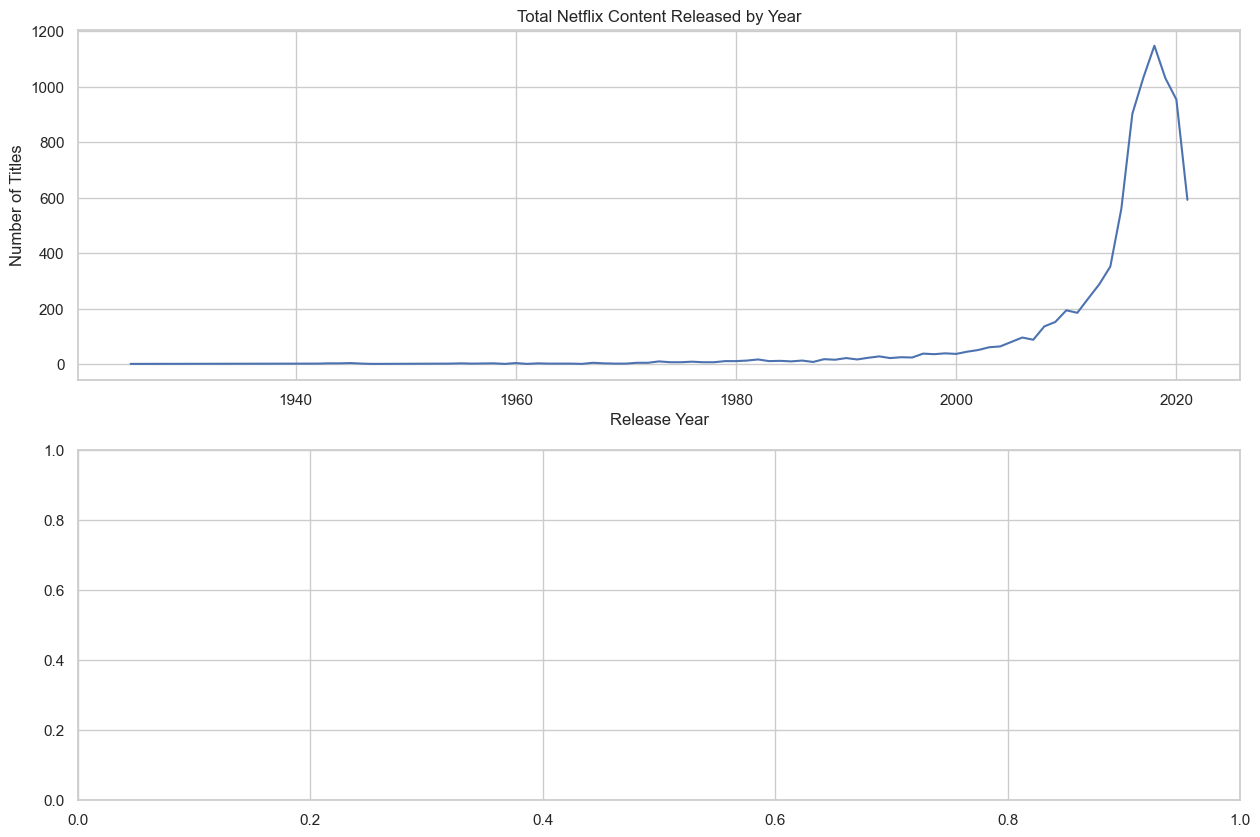

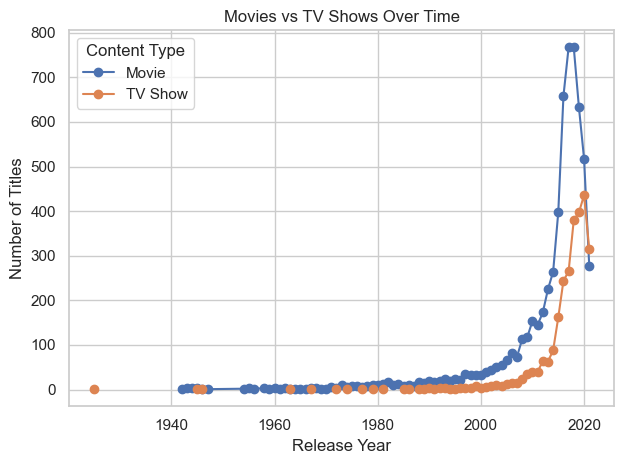


Content Production During COVID-19 Period (2018-2022):


type,Movie,TV Show
release_year,,
2018,767,380
2019,633,397
2020,517,436
2021,277,315



Year-over-Year Growth Rates (%):


type,Movie,TV Show
release_year,,
2018,NaN,NaN
2019,-17.47,4.47
2020,-18.33,9.82
2021,-46.42,-27.75


In [129]:
# Content Growth Analysis
plt.figure(figsize=(15, 10))

# Plot 1: Overall content growth
plt.subplot(2, 1, 1)
yearly_content = df_clean.groupby('release_year').size()
sns.lineplot(x=yearly_content.index, y=yearly_content.values)
plt.title('Total Netflix Content Released by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')

# Plot 2: Movies vs TV Shows
plt.subplot(2, 1, 2)
type_by_year = df_clean.groupby(['release_year', 'type']).size().unstack()
type_by_year.plot(kind='line', marker='o')
plt.title('Movies vs TV Shows Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Titles')
plt.legend(title='Content Type')

plt.tight_layout()
plt.show()

# COVID-19 Impact Analysis (2018-2022)
covid_period = df_clean[df_clean['release_year'].between(2018, 2022)]
covid_analysis = covid_period.groupby(['release_year', 'type']).size().unstack()
print("\nContent Production During COVID-19 Period (2018-2022):")
display(covid_analysis)

# Calculate year-over-year growth rates
yoy_growth = covid_analysis.pct_change() * 100
print("\nYear-over-Year Growth Rates (%):")
display(yoy_growth.round(2))


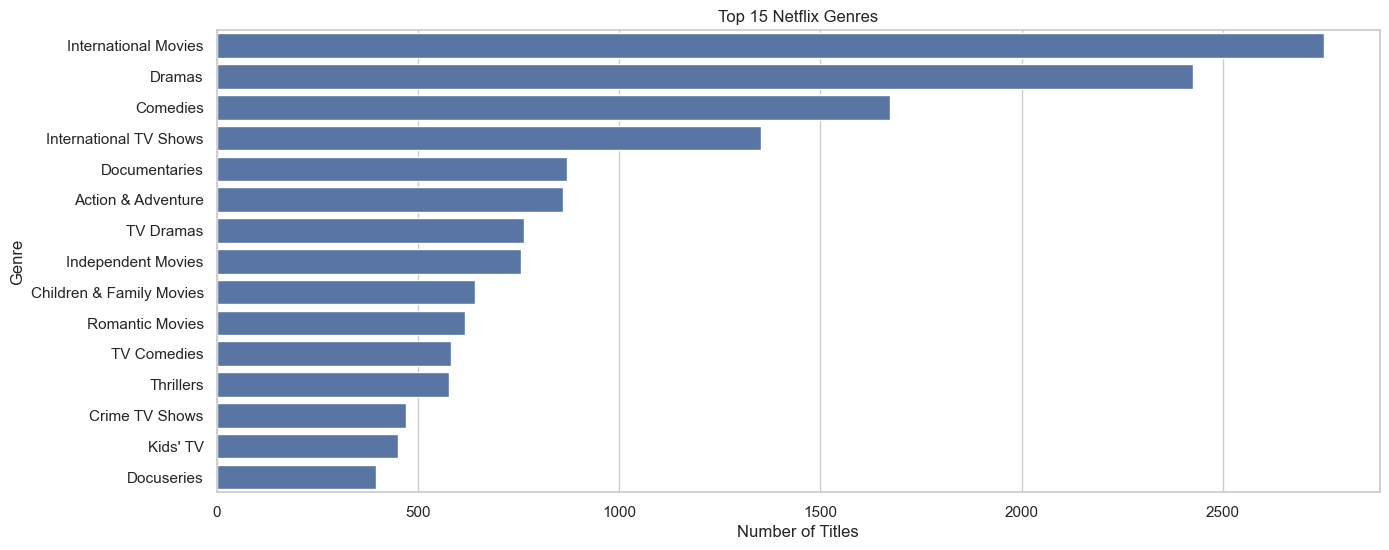

<Figure size 1200x600 with 0 Axes>

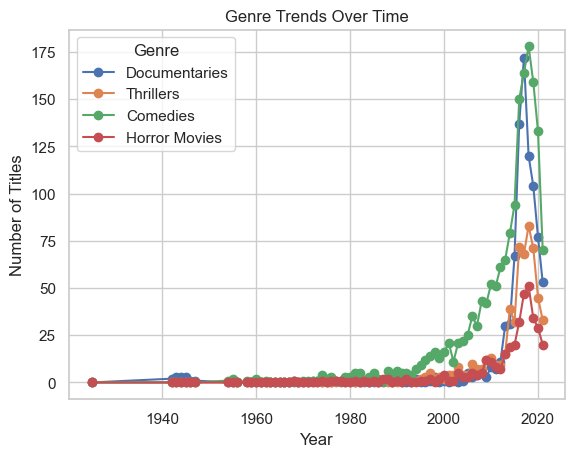

<Figure size 1500x800 with 0 Axes>

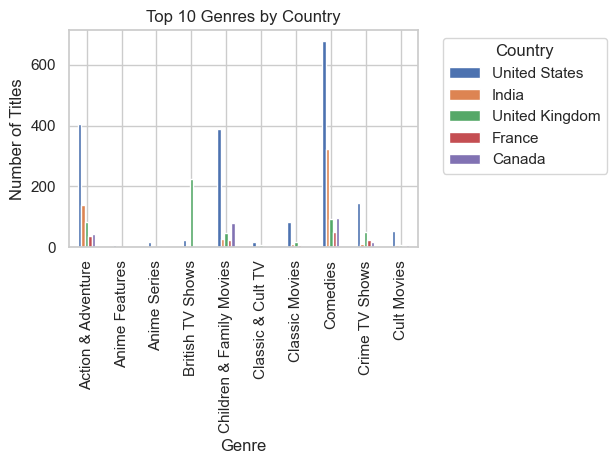

In [130]:
# Genre Analysis

# Function to count genres
def count_genres(genre_lists):
    genre_counts = {}
    for genres in genre_lists:
        if isinstance(genres, list):
            for genre in genres:
                if genre:
                    genre_counts[genre] = genre_counts.get(genre, 0) + 1
    return pd.Series(genre_counts).sort_values(ascending=False)

# Get genre distribution
genre_distribution = count_genres(df_clean['listed_in'])

# Plot top genres
plt.figure(figsize=(15, 6))
sns.barplot(x=genre_distribution.values[:15], y=genre_distribution.index[:15])
plt.title('Top 15 Netflix Genres')
plt.xlabel('Number of Titles')
plt.ylabel('Genre')
plt.show()

# Analyze genre trends over time
def get_genre_trends(df, genres_to_track=['Documentaries', 'Thrillers', 'Comedies', 'Horror Movies']):
    yearly_genre_data = {genre: [] for genre in genres_to_track}
    years = sorted(df['release_year'].unique())
    
    for year in years:
        year_data = df[df['release_year'] == year]
        for genre in genres_to_track:
            count = sum(1 for genres in year_data['listed_in'] if genre in genres)
            yearly_genre_data[genre].append(count)
    
    return pd.DataFrame(yearly_genre_data, index=years)

# Plot genre trends
genre_trends = get_genre_trends(df_clean)
plt.figure(figsize=(12, 6))
genre_trends.plot(marker='o')
plt.title('Genre Trends Over Time')
plt.xlabel('Year')
plt.ylabel('Number of Titles')
plt.legend(title='Genre')
plt.show()

# Analyze genre popularity by country
def get_top_genres_by_country(df, top_n_countries=5):
    country_genre_data = {}
    
    for _, row in df.iterrows():
        if isinstance(row['country'], list) and isinstance(row['listed_in'], list):
            for country in row['country']:
                if country:
                    if country not in country_genre_data:
                        country_genre_data[country] = {}
                    for genre in row['listed_in']:
                        if genre:
                            country_genre_data[country][genre] = country_genre_data[country].get(genre, 0) + 1
    
    # Convert to DataFrame
    country_genre_df = pd.DataFrame.from_dict({k: pd.Series(v) for k, v in country_genre_data.items()})
    
    # Get top countries by total content
    top_countries = country_genre_df.sum().sort_values(ascending=False)[:top_n_countries].index
    
    return country_genre_df[top_countries]

# Plot genre distribution for top countries
top_country_genres = get_top_genres_by_country(df_clean)
plt.figure(figsize=(15, 8))
top_country_genres.iloc[:10].plot(kind='bar')
plt.title('Top 10 Genres by Country')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.legend(title='Country', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()


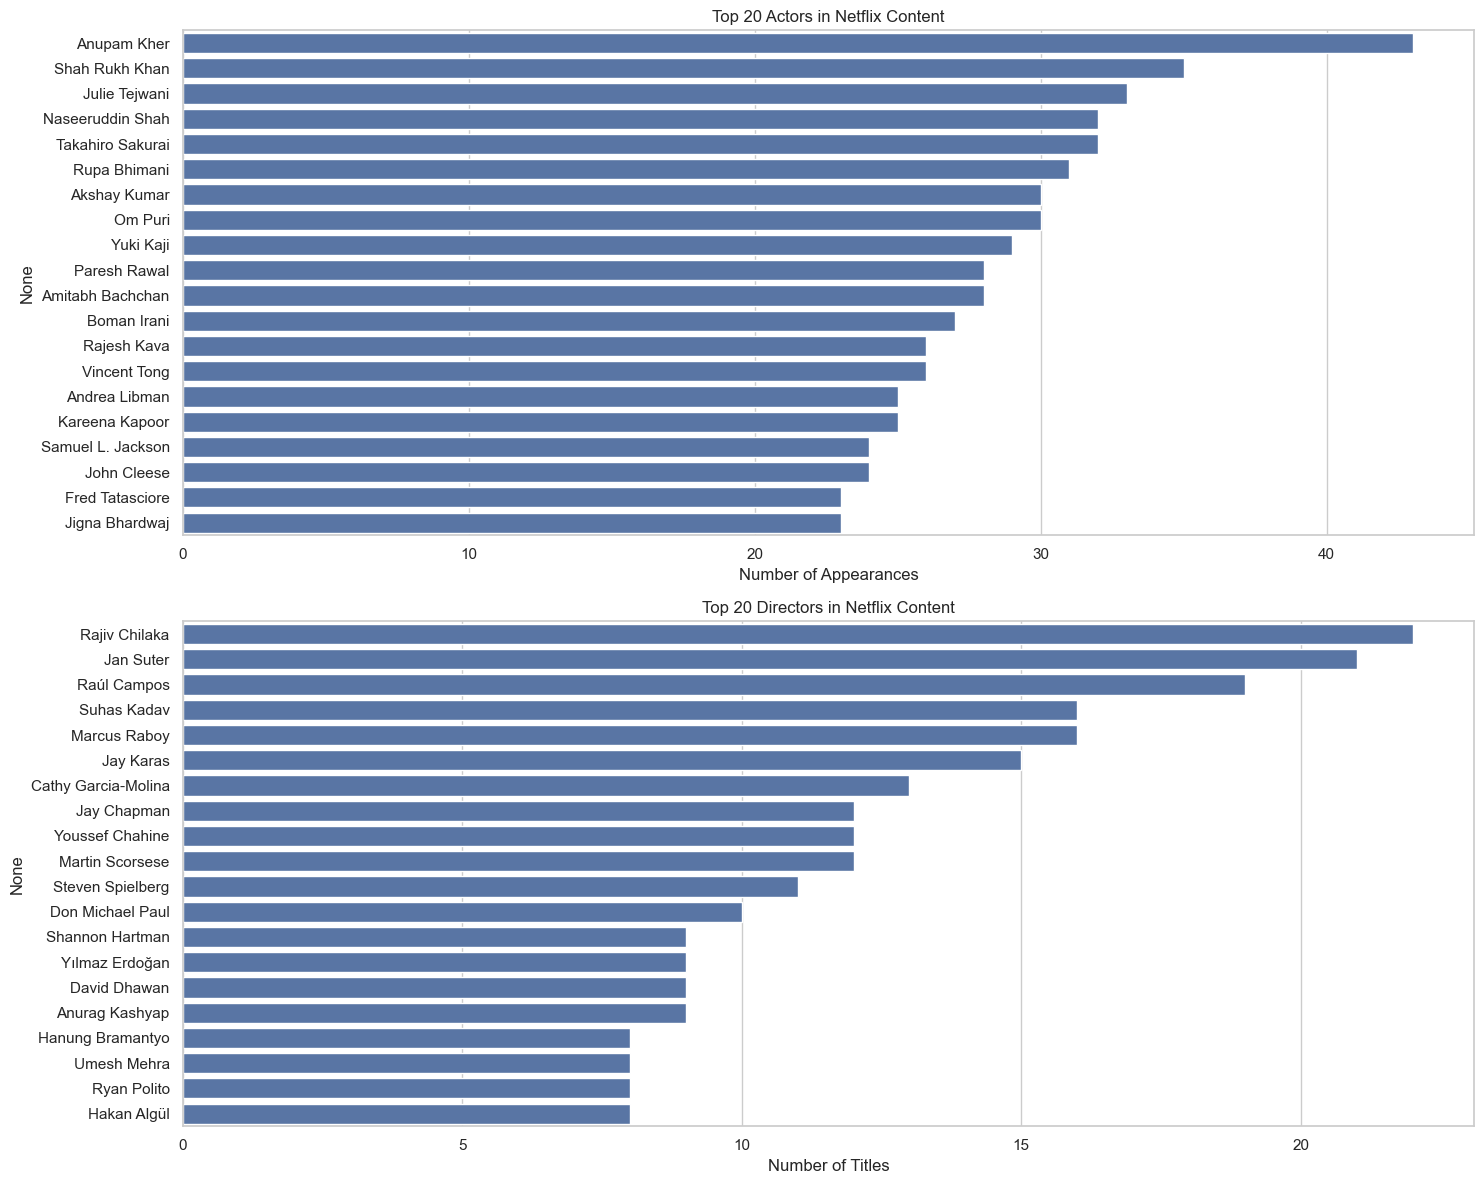

<Figure size 1500x600 with 0 Axes>

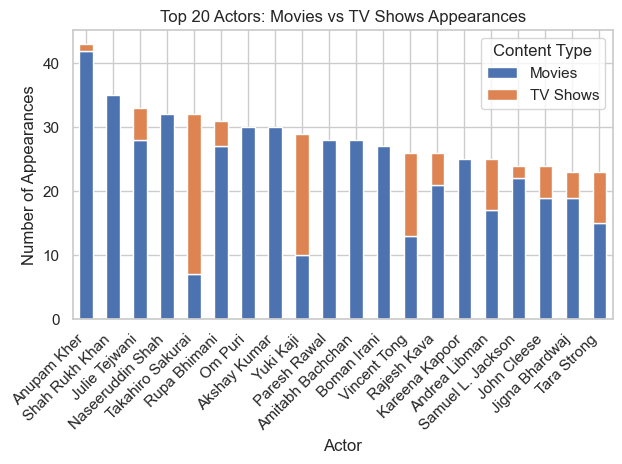


Interesting Statistics:
Number of actors who appeared in both movies and TV shows: 12

Top 5 actors with most diverse appearances (both movies and TV shows):


,Movies,TV Shows,Total
Anupam Kher,42.0,1.0,43.0
Julie Tejwani,28.0,5.0,33.0
Takahiro Sakurai,7.0,25.0,32.0
Rupa Bhimani,27.0,4.0,31.0
Yuki Kaji,10.0,19.0,29.0


In [131]:
# Cast and Director Analysis

# Function to count appearances
def count_appearances(person_lists):
    appearances = {}
    for persons in person_lists:
        if isinstance(persons, list):
            for person in persons:
                if person:
                    appearances[person] = appearances.get(person, 0) + 1
    return pd.Series(appearances).sort_values(ascending=False)

# Get top actors and directors
top_actors = count_appearances(df_clean['cast'])[:20]
top_directors = count_appearances(df_clean['director'])[:20]

# Create subplots for top actors and directors
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 12))

# Plot top actors
sns.barplot(x=top_actors.values, y=top_actors.index, ax=ax1)
ax1.set_title('Top 20 Actors in Netflix Content')
ax1.set_xlabel('Number of Appearances')

# Plot top directors
sns.barplot(x=top_directors.values, y=top_directors.index, ax=ax2)
ax2.set_title('Top 20 Directors in Netflix Content')
ax2.set_xlabel('Number of Titles')

plt.tight_layout()
plt.show()

# Analyze star power in movies vs TV shows
def analyze_star_power(df):
    movie_stars = {}
    tv_stars = {}
    
    for _, row in df.iterrows():
        if isinstance(row['cast'], list):
            for actor in row['cast']:
                if actor:
                    if row['type'] == 'Movie':
                        movie_stars[actor] = movie_stars.get(actor, 0) + 1
                    else:
                        tv_stars[actor] = tv_stars.get(actor, 0) + 1
    
    return pd.DataFrame({
        'Movies': pd.Series(movie_stars),
        'TV Shows': pd.Series(tv_stars)
    }).fillna(0)

star_power = analyze_star_power(df_clean)
star_power['Total'] = star_power['Movies'] + star_power['TV Shows']
star_power = star_power.sort_values('Total', ascending=False)[:20]

# Plot star power distribution
plt.figure(figsize=(15, 6))
star_power[['Movies', 'TV Shows']].plot(kind='bar', stacked=True)
plt.title('Top 20 Actors: Movies vs TV Shows Appearances')
plt.xlabel('Actor')
plt.ylabel('Number of Appearances')
plt.legend(title='Content Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print some interesting statistics
print("\nInteresting Statistics:")
print(f"Number of actors who appeared in both movies and TV shows: {sum((star_power['Movies'] > 0) & (star_power['TV Shows'] > 0))}")
print("\nTop 5 actors with most diverse appearances (both movies and TV shows):")
diversity_score = (star_power['Movies'] > 0).astype(int) + (star_power['TV Shows'] > 0).astype(int)
diverse_actors = star_power[diversity_score == 2].sort_values('Total', ascending=False)[:5]
display(diverse_actors)


In [119]:
## 5. Content Duration Analysis ⏱️

Analyzing the length of Netflix content:
- Duration distribution for movies and TV shows
- Outlier analysis
- Duration trends across genres


SyntaxError: invalid syntax (2267086414.py, line 3)

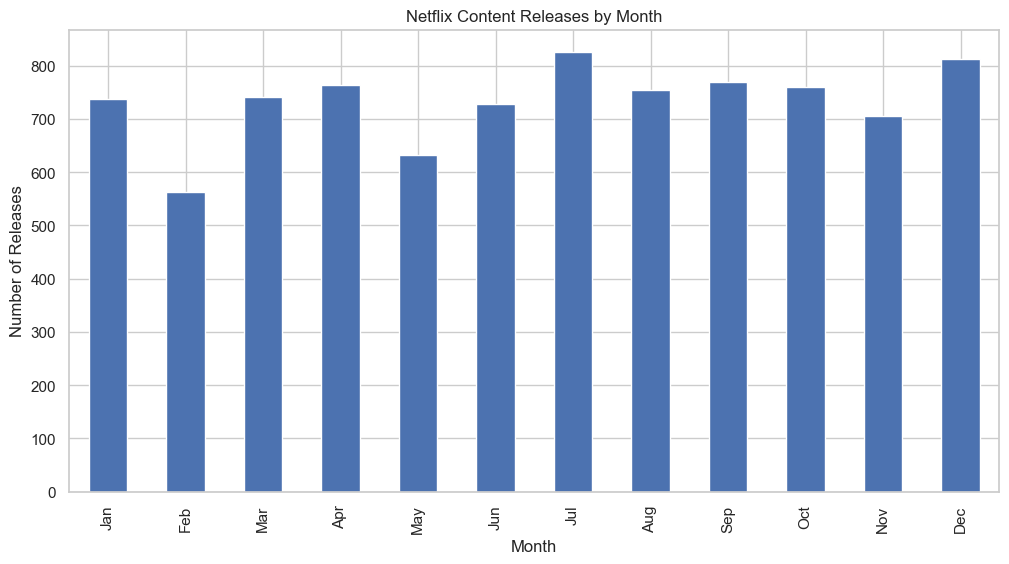

<Figure size 1500x600 with 0 Axes>

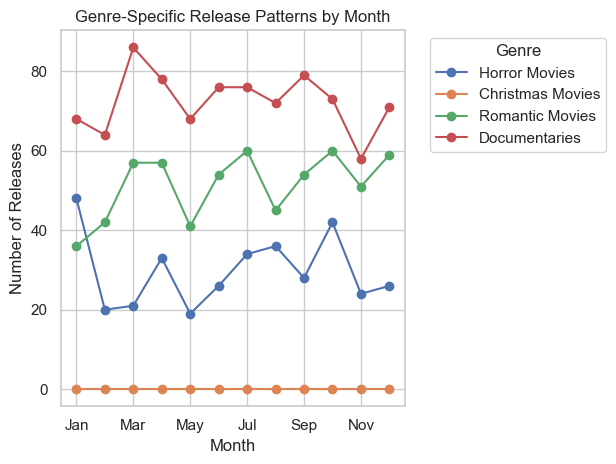

<Figure size 1000x600 with 0 Axes>

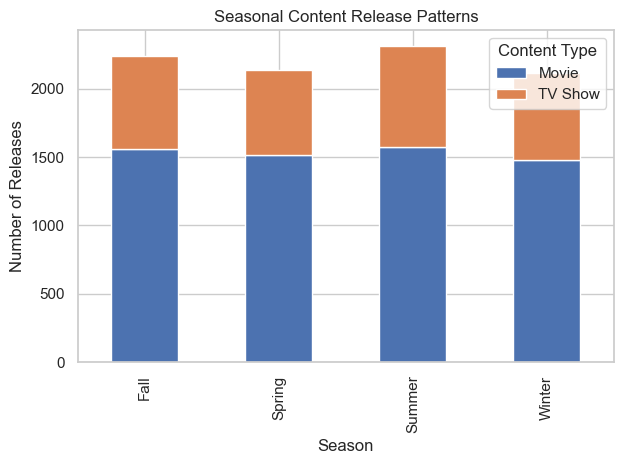


Interesting Release Pattern Findings:
Most active release month: 7.0 (827 releases)
Least active release month: 2.0 (563 releases)

Seasonal Release Distribution:


type,Movie,TV Show
season,,
Fall,1562,673
Spring,1518,620
Summer,1576,734
Winter,1475,639


In [122]:
# Release Pattern Analysis

# Monthly release patterns
monthly_releases = df_clean.groupby('month_added').size()

plt.figure(figsize=(12, 6))
monthly_releases.plot(kind='bar')
plt.title('Netflix Content Releases by Month')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Analyze genre releases by month
def analyze_monthly_genre_releases(df, genres_of_interest=['Horror Movies', 'Christmas Movies', 'Romantic Movies', 'Documentaries']):
    # Initialize a DataFrame with zeros
    monthly_genre_releases = pd.DataFrame(0, 
                                        index=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
                                        columns=genres_of_interest)
    
    # Fill in the counts
    for _, row in df.iterrows():
        if isinstance(row['listed_in'], list) and pd.notnull(row['month_added']):
            month_idx = int(row['month_added']) - 1  # Convert to 0-based index
            month_name = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'][month_idx]
            for genre in genres_of_interest:
                if genre in row['listed_in']:
                    monthly_genre_releases.loc[month_name, genre] += 1
    
    return monthly_genre_releases

# Plot genre-specific monthly releases
genre_monthly_releases = analyze_monthly_genre_releases(df_clean)
plt.figure(figsize=(15, 6))
genre_monthly_releases.plot(kind='line', marker='o')
plt.title('Genre-Specific Release Patterns by Month')
plt.xlabel('Month')
plt.ylabel('Number of Releases')
plt.legend(title='Genre', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

# Analyze seasonal trends
def get_season(month):
    if isinstance(month, (int, float)) and not pd.isna(month):
        month = int(month)
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        else:
            return 'Fall'
    return None

df_clean['season'] = df_clean['month_added'].apply(get_season)
seasonal_releases = df_clean.groupby(['season', 'type']).size().unstack()

plt.figure(figsize=(10, 6))
seasonal_releases.plot(kind='bar', stacked=True)
plt.title('Seasonal Content Release Patterns')
plt.xlabel('Season')
plt.ylabel('Number of Releases')
plt.legend(title='Content Type')
plt.tight_layout()
plt.show()

# Print some interesting findings
print("\nInteresting Release Pattern Findings:")
print(f"Most active release month: {monthly_releases.idxmax()} ({monthly_releases.max()} releases)")
print(f"Least active release month: {monthly_releases.idxmin()} ({monthly_releases.min()} releases)")
print("\nSeasonal Release Distribution:")
display(seasonal_releases)


<Figure size 1500x600 with 0 Axes>

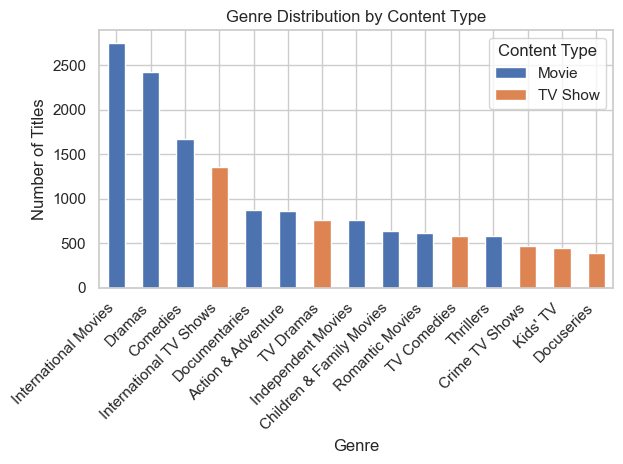

<Figure size 1200x600 with 0 Axes>

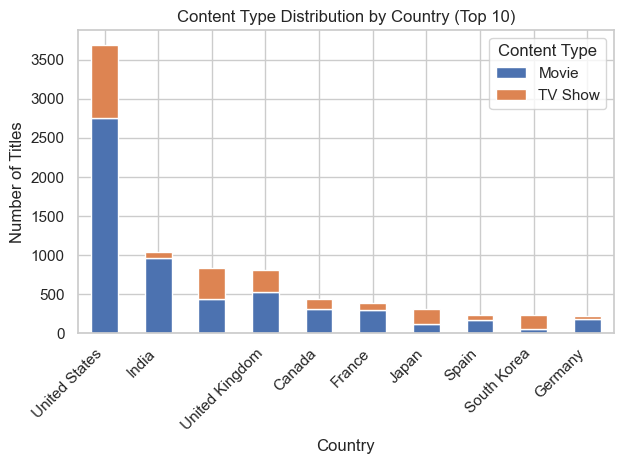


Content Type Summary Statistics:

Overall Distribution:


type
Movie      6131
TV Show    2676
Name: count, dtype: int64


Top 5 Countries with Highest Movie to TV Show Ratio:


India            11.452381
Germany           4.136364
France            3.366667
United States     2.933902
Spain             2.803279
dtype: float64


Top 5 Countries with Highest TV Show to Movie Ratio:


South Korea       2.786885
Japan             1.672269
                  0.878924
United Kingdom    0.509363
Canada            0.394984
dtype: float64

In [133]:
# TV vs. Movie Comparison Analysis


# Genre distribution by content type
def analyze_genre_by_type(df):
    genre_type_dist = {}
    
    for _, row in df.iterrows():
        if isinstance(row['listed_in'], list):
            for genre in row['listed_in']:
                if genre not in genre_type_dist:
                    genre_type_dist[genre] = {'Movie': 0, 'TV Show': 0}
                genre_type_dist[genre][row['type']] += 1
    
    return pd.DataFrame.from_dict(genre_type_dist, orient='index')

genre_distribution = analyze_genre_by_type(df_clean)
genre_distribution['Total'] = genre_distribution.sum(axis=1)
genre_distribution = genre_distribution.sort_values('Total', ascending=False)[:15]

plt.figure(figsize=(15, 6))
genre_distribution[['Movie', 'TV Show']].plot(kind='bar', stacked=True)
plt.title('Genre Distribution by Content Type')
plt.xlabel('Genre')
plt.ylabel('Number of Titles')
plt.legend(title='Content Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Regional preferences
def analyze_regional_preferences(df):
    country_preferences = {}
    
    for _, row in df.iterrows():
        if isinstance(row['country'], list):
            for country in row['country']:
                if country not in country_preferences:
                    country_preferences[country] = {'Movie': 0, 'TV Show': 0}
                country_preferences[country][row['type']] += 1
    
    return pd.DataFrame.from_dict(country_preferences, orient='index')

country_preferences = analyze_regional_preferences(df_clean)
country_preferences['Total'] = country_preferences.sum(axis=1)
country_preferences = country_preferences.sort_values('Total', ascending=False)[:10]

plt.figure(figsize=(12, 6))
country_preferences[['Movie', 'TV Show']].plot(kind='bar', stacked=True)
plt.title('Content Type Distribution by Country (Top 10)')
plt.xlabel('Country')
plt.ylabel('Number of Titles')
plt.legend(title='Content Type')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nContent Type Summary Statistics:")
print("\nOverall Distribution:")
display(content_ratio)
print("\nTop 5 Countries with Highest Movie to TV Show Ratio:")
movie_tv_ratio = country_preferences['Movie'] / country_preferences['TV Show']
display(movie_tv_ratio.sort_values(ascending=False)[:5])
print("\nTop 5 Countries with Highest TV Show to Movie Ratio:")
tv_movie_ratio = country_preferences['TV Show'] / country_preferences['Movie']
display(tv_movie_ratio.sort_values(ascending=False)[:5])


In [101]:
# Advanced Analysis using Machine Learning

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Text preprocessing for descriptions
def preprocess_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase and remove special characters
    text = text.lower()
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])
    return text

# Prepare data for NLP
df_clean['processed_description'] = df_clean['description'].apply(preprocess_text)

# Create TF-IDF vectors
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
description_vectors = tfidf.fit_transform(df_clean['processed_description'])

# Perform clustering
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(description_vectors)
df_clean['content_cluster'] = clusters

# Analyze clusters
cluster_analysis = pd.DataFrame()
for i in range(n_clusters):
    cluster_docs = df_clean[df_clean['content_cluster'] == i]['processed_description']
    cluster_vectors = tfidf.transform(cluster_docs)
    cluster_center = cluster_vectors.mean(axis=0).A1
    top_terms = [tfidf.get_feature_names_out()[i] for i in cluster_center.argsort()[-10:][::-1]]
    cluster_analysis[f'Cluster {i}'] = top_terms

print("Top terms in each content cluster:")
display(cluster_analysis)



# Simple content-based recommendation system
def get_recommendations(title, n=5):
    # Find the index of the title
    idx = df_clean[df_clean['title'] == title].index
    if len(idx) == 0:
        return "Title not found"
    
    # Get the description vector for the title
    title_vector = description_vectors[idx[0]]
    
    # Calculate similarity with all other titles
    similarities = description_vectors.dot(title_vector.T).toarray().flatten()
    
    # Get indices of most similar titles (excluding the input title)
    similar_indices = similarities.argsort()[::-1][1:n+1]
    
    return df_clean.iloc[similar_indices][['title', 'type', 'listed_in']]

# Example recommendations
print("\nExample Content Recommendations:")
example_title = df_clean['title'].iloc[0]
print(f"\nRecommendations for '{example_title}':")
display(get_recommendations(example_title))


[nltk_data] Downloading package stopwords to C:\Users\Son
[nltk_data]     Dong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top terms in each content cluster:


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4
0,young,family,world,lives,life
1,new,documentary,war,women,series
2,friends,follows,ii,young,love
3,man,young,new,series,new
4,love,series,young,friends,young
5,woman,new,documentary,new,family
6,help,man,save,woman,man
7,finds,years,way,group,woman
8,school,explores,life,family,stories
9,home,woman,series,documentary,reality



Example Content Recommendations:

Recommendations for 'Dick Johnson Is Dead':


,title,type,listed_in
6327,Black Snake Moan,Movie,"[Dramas, Independent Movies]"
2429,Can’t Complain,Movie,"[Comedies, International Movies, Romantic Movies]"
823,Then Came You,Movie,"[Comedies, Dramas, Independent Movies]"
4714,Brij Mohan Amar Rahe,Movie,"[Comedies, Dramas, International Movies]"
2760,Kannum Kannum Kollaiyadithaal,Movie,"[Comedies, Dramas, International Movies]"


In [94]:
# Genre Prediction Analysis

# Get the primary genre for each title
df_clean['primary_genre'] = df_clean['listed_in'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Filter out rows with no genre
genre_prediction_data = df_clean[df_clean['primary_genre'].notna()]

# Prepare features and target
X = description_vectors[genre_prediction_data.index]
y = genre_prediction_data['primary_genre']

# Get unique genres and their counts
genre_counts = y.value_counts()
print("Number of titles per genre:")
display(genre_counts)

# Encode genres
le = LabelEncoder()
y = le.fit_transform(genre_prediction_data['primary_genre'])

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a simple classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Get unique labels that appear in both test and predicted data
unique_labels = np.unique(y_test)
target_names = le.inverse_transform(unique_labels)

# Print classification report with explicit labels
print("\nGenre Prediction Results:")
print(classification_report(
    y_test, 
    y_pred,
    labels=unique_labels,
    target_names=target_names,
    zero_division=0
))


Number of titles per genre:


primary_genre
Dramas                          1600
Comedies                        1210
Action & Adventure               859
Documentaries                    829
International TV Shows           774
Children & Family Movies         605
Crime TV Shows                   399
Kids' TV                         388
Stand-Up Comedy                  334
Horror Movies                    275
British TV Shows                 253
Docuseries                       221
Anime Series                     176
International Movies             128
TV Comedies                      120
Reality TV                       120
Classic Movies                    80
TV Dramas                         67
Thrillers                         65
Movies                            57
TV Action & Adventure             40
Stand-Up Comedy & Talk Shows      34
Romantic TV Shows                 32
Classic & Cult TV                 22
Anime Features                    21
Independent Movies                20
Music & Musicals        


Genre Prediction Results:
                              precision    recall  f1-score   support

          Action & Adventure       0.44      0.54      0.49       172
              Anime Features       0.00      0.00      0.00         3
                Anime Series       0.50      0.03      0.05        39
            British TV Shows       0.14      0.02      0.03        52
    Children & Family Movies       0.36      0.34      0.35       122
           Classic & Cult TV       0.00      0.00      0.00         3
              Classic Movies       0.00      0.00      0.00        20
                    Comedies       0.30      0.47      0.37       231
              Crime TV Shows       0.29      0.13      0.18        89
                 Cult Movies       0.00      0.00      0.00         6
               Documentaries       0.59      0.62      0.61       151
                  Docuseries       0.52      0.22      0.31        51
                      Dramas       0.36      0.62      0.46   